In [2]:
the_time = "20240530_225608"
image_file = "https://www.denverpost.com/wp-content/uploads/2016/04/20130508__20130509_Z00_FE09STGATSBYp3.jpg"

In [3]:
import json

with open(f"attention_results/{the_time}_attention_weights.json", "r") as file:
    attention_description = json.load(file)

    # Remove the 'attention_description' key if it exists
    if 'attention_description' in attention_description:
        del attention_description['attention_description']

    # Display the content of the JSON file nicely
    import pprint

    # pp = pprint.PrettyPrinter(indent=4)
    # pp.pprint(attention_description)


In [4]:
# Print the length of all tokens
all_tokens = attention_description.get("all_tokens", [])
print(f"Length of all tokens: {len(all_tokens)}")


Length of all tokens: 1051


In [5]:
import torch

# Load the attention results from the specified file
attention_results_path = f"attention_results/{the_time}_attentions.pt"
attentions = torch.load(attention_results_path, map_location=torch.device('cpu'))

In [6]:
import numpy as np

num_decoders = 32
num_heads = 32
attention_matrices = np.array([])

for decoder_no in range(num_decoders):
    decoder_attention_matrices = np.array([])
    for attention_head in range(num_heads):
        final_size = attentions[-1][decoder_no][0, attention_head, :].shape[1]
        attention_matrix = np.zeros((final_size, final_size))

        first_matrix = np.array(attentions[0][decoder_no][0, attention_head, :])
        first_matrix_height = first_matrix.shape[0]

        # Insert the first_matrix into the top left corner of attention_matrix
        attention_matrix[:first_matrix.shape[0], :first_matrix.shape[1]] = first_matrix

        for generated_token_index, attention in enumerate(attentions[1:], start=0):
            new_token_row = np.array(attention[decoder_no][0, attention_head, :])
            new_token_row = np.pad(new_token_row, ((0, 0), (0, final_size - new_token_row.shape[1])), 'constant')

            attention_matrix[first_matrix_height + generated_token_index] = new_token_row

        # is_lower_triangular = np.allclose(attention_matrix, np.tril(attention_matrix))
        # print(f"Is the attention matrix for decoder {decoder_no}, head {attention_head} a lower triangular matrix? {is_lower_triangular}")
        decoder_attention_matrices = np.append(decoder_attention_matrices, [attention_matrix], axis=0) if decoder_attention_matrices.size else np.array([attention_matrix])
    attention_matrices = np.append(attention_matrices, [decoder_attention_matrices], axis=0) if attention_matrices.size else np.array([decoder_attention_matrices])



In [20]:
average_attention_matrix = np.mean(attention_matrices, axis=(0, 1))

In [14]:
output_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["output_tokens"]]
input_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["input_tokens"]]

image_token_indices = [i for i, token in enumerate(input_tokens) if token.startswith("image_")]
x_image_token_start = image_token_indices[0]
x_image_token_end = image_token_indices[-1] + 1
main_input_text = input_tokens[x_image_token_end + 1:len(input_tokens)]


In [122]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
from io import BytesIO
from ipywidgets import Button, HBox, VBox, Output, Layout
from IPython.display import display

def preprocess_image(image):
    # Example preprocessing: resize and convert to RGB
    return image.resize((384, 384)).convert("RGB")

def plot_average_attention_matrix(idx):
    # Load the image from the URL
    image_url = image_file
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Preprocess the image
    scaled_image = preprocess_image(image)

    # Create 27 x 27 patches
    patch_size = 384 // 27
    
    # Reshape the average attention matrix to 27 x 27
    output_row = average_attention_matrix[len(input_tokens) + idx, :]
    avg_attention_reshaped = np.reshape(output_row[x_image_token_start:x_image_token_end], (27, 27))
    
    # Overlay the average attention map on the image
    avg_patched_image = scaled_image.copy()
    draw = ImageDraw.Draw(avg_patched_image, "RGBA")

    for i in range(27):
        for j in range(27):
            x0 = j * patch_size
            y0 = i * patch_size
            x1 = x0 + patch_size
            y1 = y0 + patch_size
            # Normalize the opacity to be between 0 and 1
            opacity = avg_attention_reshaped[i, j] / 0.0002
            draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 255, int(255 * opacity)))

    plt.figure(figsize=(10, 10))
    plt.imshow(avg_patched_image)
    plt.title(f'Average Attention Map Across All Heads for Output Token Index {idx}')
    plt.show()

# Create buttons for each output token index
output = Output()
buttons = [Button(description=f"{i}: {token}") for i, token in enumerate(output_tokens)]

def on_button_click(b):
    idx = int(b.description.split(":")[0])
    with output:
        output.clear_output()
        plot_average_attention_matrix(idx)

for button in buttons:
    button.on_click(on_button_click)

# Display buttons side by side with spacing between them
token_button_box = HBox(buttons, layout=Layout(justify_content='space-between', flex_flow='row wrap', gap='10px'))
display(VBox([token_button_box, output]))

In [27]:
from ipywidgets import Button, HBox, VBox, Output, Label
from IPython.display import display

output = Output()

def update_bar_graph(output_idx):
    with output:
        output.clear_output()
        print(output_tokens[output_idx])
        output_relevancy = average_attention_matrix[len(input_tokens) + output_idx, :]
        image_tokens = output_relevancy[x_image_token_start:x_image_token_end]
        average_image_tokens = np.mean(image_tokens)
        max_image_tokens = np.max(image_tokens)

        text_tokens = output_relevancy[x_image_token_end + 1:len(input_tokens)-3]
        text_tokens_label = input_tokens[x_image_token_end + 1:len(input_tokens)-3]

        # Define the labels and values for the bar graph
        labels = text_tokens_label + ["average_img"]
        values = np.append(text_tokens, [average_image_tokens])

        # labels = text_tokens_label + ["max_img", "average_img"]
        # values = np.append(text_tokens, [max_image_tokens, average_image_tokens])

        # Create the bar graph
        plt.figure(figsize=(10, 6))
        plt.bar(labels, values, color='skyblue')

        # Add title and labels
        plt.title('Relevancy Scores for Text and Image Tokens')
        plt.xlabel('Tokens')
        plt.ylabel('Relevancy Score')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=90)

        # Display the bar graph
        plt.tight_layout()
        plt.show()

# Create buttons for each output token
token_buttons = [Button(description=f"{idx}: {token}") for idx, token in enumerate(output_tokens)]

def on_token_button_click(b):
    output_idx = int(b.description.split(":")[0])
    update_bar_graph(output_idx)

for button in token_buttons:
    button.on_click(on_token_button_click)

# Display buttons side by side with spacing between them
token_button_box = HBox(token_buttons, layout=Layout(justify_content='space-between', flex_flow='row wrap', gap='10px'))
display(VBox([token_button_box, output]))

# Initialize the bar graph with the first token
update_bar_graph(0)


/tmp/joetey/ipykernel_3162396/3996445287.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


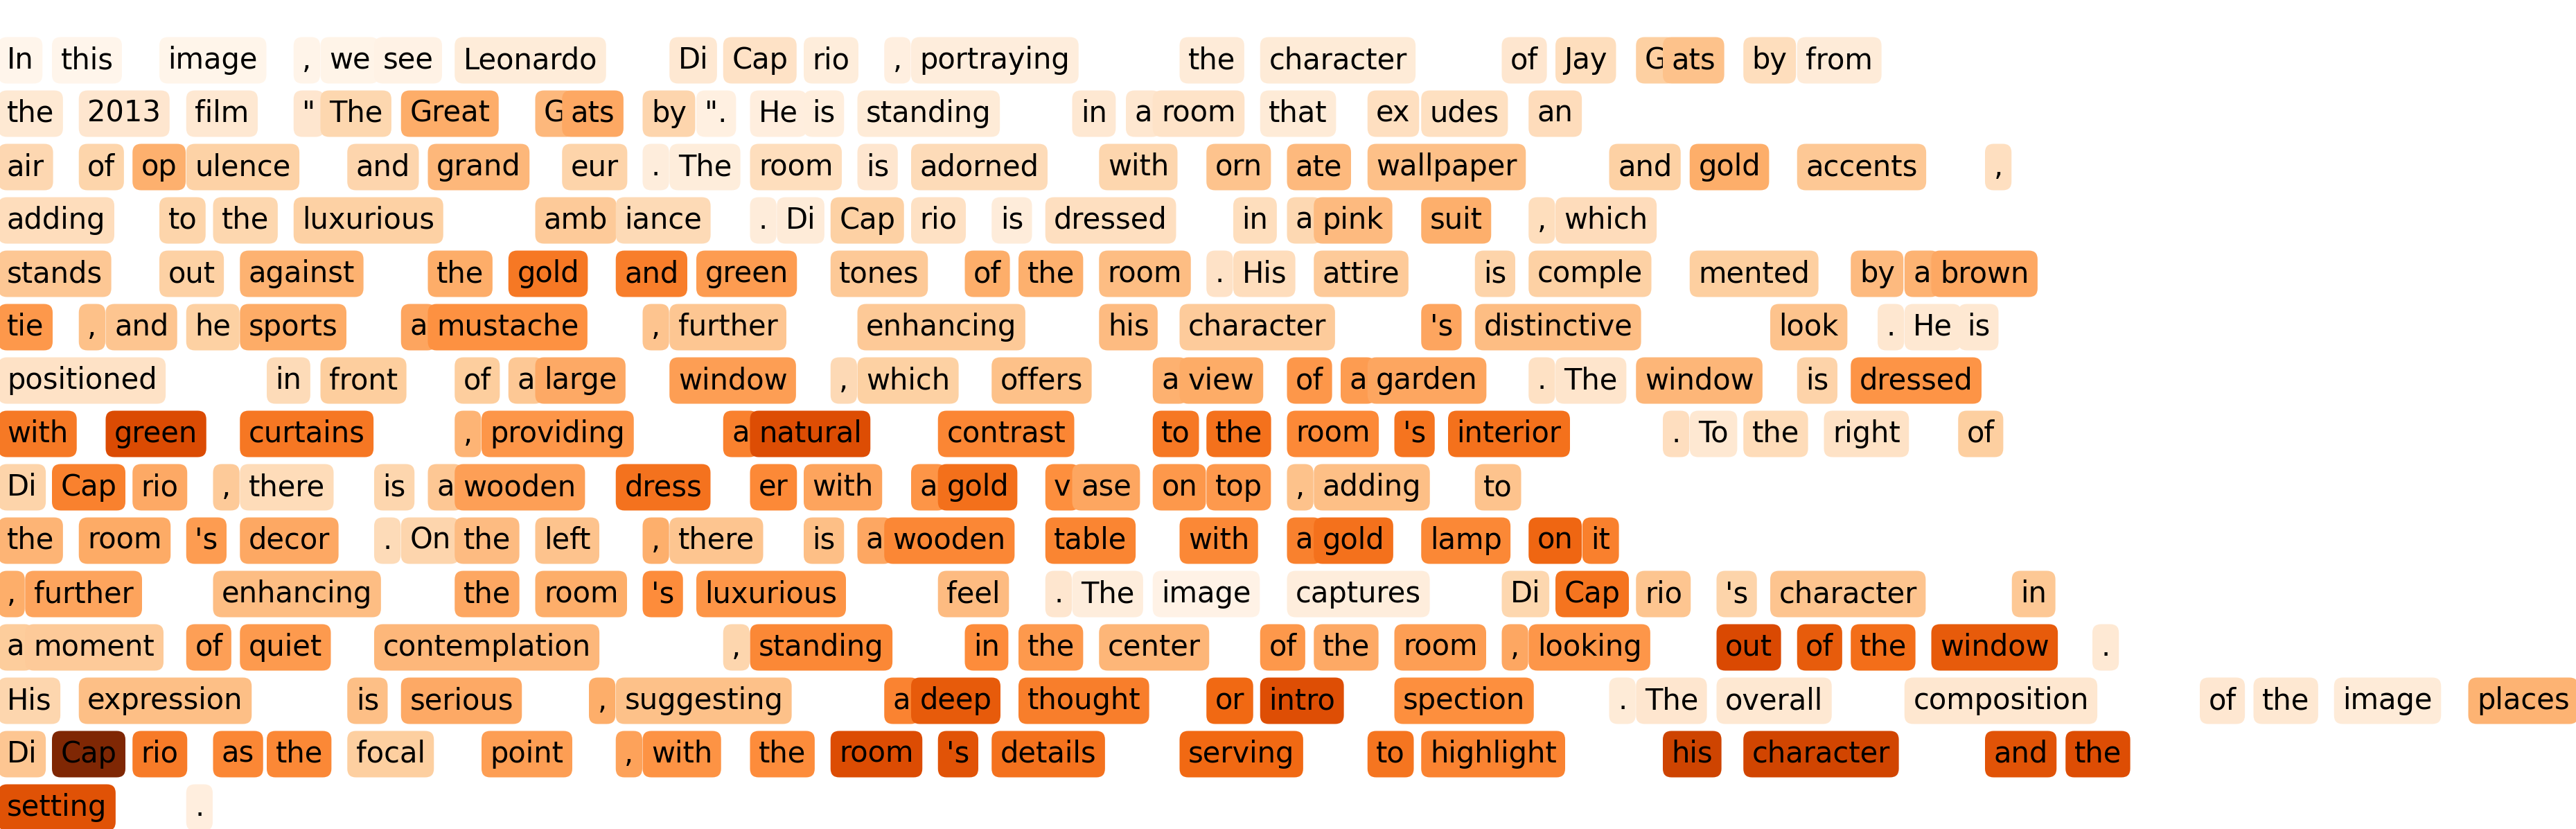

In [108]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 2))

# Function to split text into chunks of a given character limit
def split_text(text, char_limit=20):
    return [text[i:i + char_limit] for i in range(0, len(text), char_limit)]

# Calculate the average image tokens for each output token before normalizing
average_ratio_list = []
for i, output_token in enumerate(output_tokens):
    output_relevancy = average_attention_matrix[len(input_tokens) + i, :]
    image_tokens = output_relevancy[x_image_token_start:x_image_token_end]
    text_tokens = output_relevancy[x_image_token_end + 1:len(input_tokens)-3]

    average_text_tokens = np.mean(text_tokens)
    average_image_tokens = np.mean(image_tokens)
    average_ratio_list.append(average_image_tokens/average_text_tokens)

# Normalize the average image token relevancy scores to a range of 0 to 1
vmin = min(average_ratio_list)
vmax = max(average_ratio_list)

# Normalize the values based on the actual range
norm = Normalize(vmin=vmin, vmax=vmax)
normalized_values = norm(average_ratio_list)
cmap = cm.Oranges

# Plot each token with a background color based on its average image token relevancy score
x_coord = 0
y_coord = 0.5
for i, (output_token, normalized_value) in enumerate(zip(output_tokens, normalized_values)):
    color = cmap(normalized_value)
    ax.text(x_coord, y_coord, output_token, ha='left', va='center', fontsize=30, 
            bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x_coord += (len(output_token)/6)
    if (i + 1) % 20 == 0:
        x_coord = 0
        y_coord -= 0.5  # Shift down a little for every 5 tokens
# Remove axes
ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


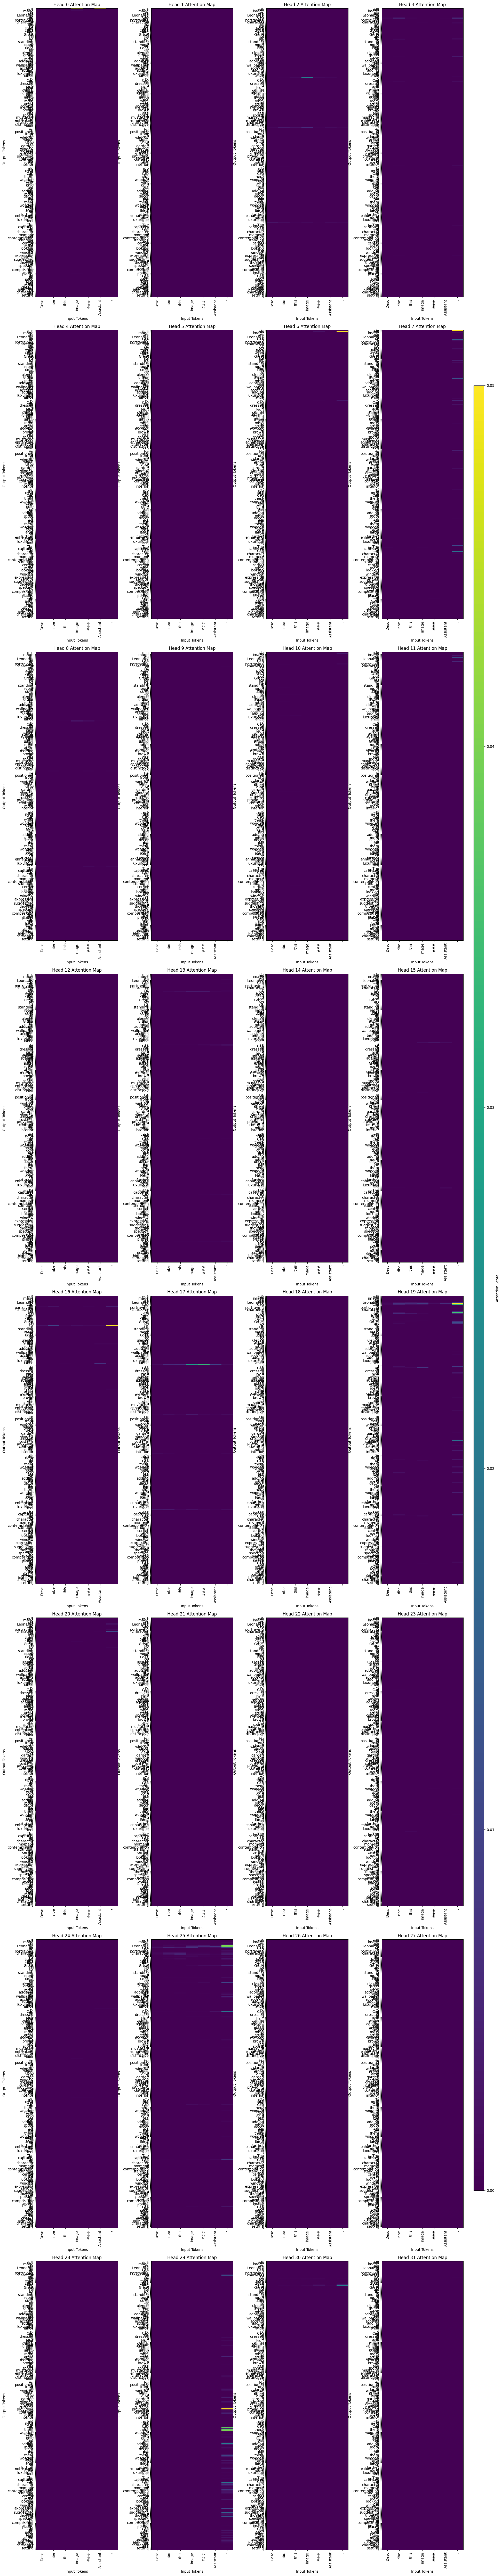

In [9]:
import matplotlib.pyplot as plt

image_token_indices = [i for i, token in enumerate(input_tokens) if token.startswith("image_")]
x_image_token_start = image_token_indices[0]
x_image_token_end = image_token_indices[-1] + 1

main_input_text = input_tokens[x_image_token_end + 1:len(input_tokens)]

# Define the decoder number to use
decoder_no = 31

# Create a figure with a grid of subplots for all attention heads
fig, axes = plt.subplots(8, 4, figsize=(20, 100))  # 8 rows and 4 columns

for attention_head in range(32):
    # Filter the attention matrix to just the top len(output_tokens) rows, and the first x_image_token_start columns
    filtered_attention_matrix = attention_matrices[decoder_no][attention_head][-len(output_tokens):, x_image_token_end + 1:len(input_tokens)]
    
    ax = axes[attention_head // 4, attention_head % 4]
    im = ax.imshow(filtered_attention_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=0.05)
    
    # Set the labels for the x and y axes using attention_description["all_tokens"]
    ax.set_xticks(np.arange(len(main_input_text)))
    ax.set_xticklabels(main_input_text, rotation=90)
    ax.set_yticks(np.arange(len(output_tokens)))
    ax.set_yticklabels(output_tokens)
    
    ax.set_ylabel('Output Tokens')
    ax.set_xlabel('Input Tokens')
    ax.set_title(f'Head {attention_head} Attention Map')

# Adjust layout and add a colorbar
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Attention Score')

plt.show()

In [10]:
# Print the whole output first
from textwrap import fill

wrapped_output = fill(attention_description["outputs"], width=80)
print(wrapped_output)
print("\n")
# Print a mapping of output_tokens and respective idx
for idx, token in enumerate(output_tokens):
    print(f"Index: {idx}, Token: {token}")



In this image, we see Leonardo DiCaprio, portraying the character of Jay Gatsby
from the 2013 film "The Great Gatsby". He is standing in a room that exudes an
air of opulence and grandeur. The room is adorned with ornate wallpaper and gold
accents, adding to the luxurious ambiance.  DiCaprio is dressed in a pink suit,
which stands out against the gold and green tones of the room. His attire is
complemented by a brown tie, and he sports a mustache, further enhancing his
character's distinctive look.  He is positioned in front of a large window,
which offers a view of a garden. The window is dressed with green curtains,
providing a natural contrast to the room's interior.  To the right of DiCaprio,
there is a wooden dresser with a gold vase on top, adding to the room's decor.
On the left, there is a wooden table with a gold lamp on it, further enhancing
the room's luxurious feel.  The image captures DiCaprio's character in a moment
of quiet contemplation, standing in the center of the ro

In [11]:
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
from ipywidgets import Button, HBox, VBox, Layout, Output, Label
from IPython.display import display

print(attention_description["outputs"])

def visualize_attention(idx, decoder_no):
    # Load the image from the URL
    print(output_tokens[idx])
    image_url = image_file
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Scale the image to 384 x 384
    scaled_image = image.resize((384, 384))

    # Create 27 x 27 patches
    patch_size = 384 // 27
    
    # Plot the average attention values across all heads
    avg_attention = np.mean([attention_matrices[decoder_no][head][len(input_tokens) + idx, x_image_token_start:x_image_token_end] for head in range(32)], axis=0)
    avg_attention_reshaped = np.reshape(avg_attention, (27, 27))
    
    # Overlay the average attention map on the image
    avg_patched_image = scaled_image.copy()
    draw = ImageDraw.Draw(avg_patched_image, "RGBA")

    for i in range(27):
        for j in range(27):
            x0 = j * patch_size
            y0 = i * patch_size
            x1 = x0 + patch_size
            y1 = y0 + patch_size
            # Normalize the opacity to be between 0 and 1
            opacity = avg_attention_reshaped[i, j] / 0.005
            draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 255, int(255 * opacity)))

    plt.figure(figsize=(10, 10))
    plt.imshow(avg_patched_image)
    plt.title('Average Attention Map Across All Heads')
    plt.show()

    # Create a figure with a grid of subplots for all attention heads
    fig, axes = plt.subplots(8, 4, figsize=(20, 20))  # 8 rows and 4 columns

    for attention_head in range(32):
        output_row = attention_matrices[decoder_no][attention_head][len(input_tokens) + idx, :]

        # Get the columns in the matrix (xlim_start, xlim_end) for the 7th row
        image_patches = output_row[x_image_token_start:x_image_token_end]
        # Ensure selected_columns is reshaped to 27x27
        image_patches_reshaped = np.reshape(image_patches, (27, 27))

        # Create a new image to draw patches on
        patched_image = scaled_image.copy()
        draw = ImageDraw.Draw(patched_image, "RGBA")

        for i in range(27):
            for j in range(27):
                x0 = j * patch_size
                y0 = i * patch_size
                x1 = x0 + patch_size
                y1 = y0 + patch_size
                # Normalize the opacity to be between 0 and 1
                opacity = image_patches_reshaped[i, j] / 0.005
                draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 255, int(255 * opacity)))

        # Display the patched image in the corresponding subplot
        ax = axes[attention_head // 4, attention_head % 4]
        ax.imshow(patched_image)
        ax.axis('off')
        ax.set_title(f'Head {attention_head}')

    # Adjust layout
    fig.tight_layout()
    plt.show()

# Create buttons for each output token and decoder number
output = Output()
token_buttons = [Button(description=f"{idx}: {token}") for idx, token in enumerate(output_tokens)]
decoder_buttons = [Button(description=f"Decoder {i}") for i in range(len(attention_matrices))]
decoder_label = Label(value="Selected Decoder: 0")


# Initialize the current decoder number
selected_token_idx = 0
current_decoder_no = 0

def on_token_button_click(b):
    global selected_token_idx
    selected_token_idx = int(b.description.split(":")[0])
    with output:
        output.clear_output()
        visualize_attention(selected_token_idx, current_decoder_no)
        # print(f"Selected Token Index: {selected_token_idx}, Current Decoder No: {current_decoder_no}")
        display_text.value = f"Selected Token Index: {selected_token_idx}"

def on_decoder_button_click(b):
    global current_decoder_no
    current_decoder_no = int(b.description.split(" ")[1])
    decoder_label.value = f"Selected Decoder: {current_decoder_no}"
    with output:
        output.clear_output()
        # print(f"Selected Decoder: {current_decoder_no}")
        if selected_token_idx is not None:
            visualize_attention(selected_token_idx, current_decoder_no)
            # print(f"Selected Token Index: {selected_token_idx}, Current Decoder No: {current_decoder_no}")
            display_text.value = f"Selected Token Index: {selected_token_idx}"

for button in token_buttons:
    button.on_click(on_token_button_click)

for button in decoder_buttons:
    button.on_click(on_decoder_button_click)

# Display buttons side by side with spacing between them
token_button_box = HBox(token_buttons, layout=Layout(justify_content='space-between', flex_flow='row wrap', gap='10px'))
decoder_button_box = HBox(decoder_buttons, layout=Layout(justify_content='space-between', flex_flow='row wrap', gap='10px'))
display_text = Label(value=f"Selected Token Index: {selected_token_idx}")
display(VBox([decoder_button_box, decoder_label, token_button_box, display_text, output]))

In this image, we see Leonardo DiCaprio, portraying the character of Jay Gatsby from the 2013 film "The Great Gatsby". He is standing in a room that exudes an air of opulence and grandeur. The room is adorned with ornate wallpaper and gold accents, adding to the luxurious ambiance.

DiCaprio is dressed in a pink suit, which stands out against the gold and green tones of the room. His attire is complemented by a brown tie, and he sports a mustache, further enhancing his character's distinctive look.

He is positioned in front of a large window, which offers a view of a garden. The window is dressed with green curtains, providing a natural contrast to the room's interior.

To the right of DiCaprio, there is a wooden dresser with a gold vase on top, adding to the room's decor. On the left, there is a wooden table with a gold lamp on it, further enhancing the room's luxurious feel.

The image captures DiCaprio's character in a moment of quiet contemplation, standing in the center of the ro